# Requirements:
1. Introduction about the dataset
2. What is the goal
3. Preprocessing text
4. Visualization
5. Report

# Rubric:
1. Definition of the dataset - Comprehensive and clear definition
2. Visualization of the Dataset Features and Results - Detailed and insightful visualizations
3. Cleaning the Text Document with Two Approaches - Effective use of two distinct cleaning approaches, with clear explanations
4. Implementation of Three Word Embedding Methods - Comprehensive and effective implementation of three methods, including one
with SpaCy
5. Comparison of the Results of Word Embedding Methods - In-depth and insightful comparison, with clear findings
6. Report and Description of Work Done - Comprehensive and well-structured report, clearly describing all aspects of the
project

# Introduction about the dataset

The dataset used in this project is a labeled dataset of fake news articles, collected from various sources. The dataset contains 21261 instances, with each instance containing a title, text, and label (true or fake). The labels are represented as 0 for fake news and 1 for true news.

# What is the goal

The goal of this project is to develop a machine learning model that can accurately classify fake news articles based on their content. By leveraging various word embedding techniques, such as Word2Vec, GloVe, and FastText, we will explore the potential of these models in detecting and distinguishing fake news.

# Preprocessing text

## Loading dataset from CSV

In [9]:
import time
import spacy
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from spacy.language import Language
from spacy.tokens import Doc
from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Enable GPU if available
if spacy.require_gpu():
    print("GPU is enabled!")
else:
    print("GPU not available.")

# Decorator to measure time of the function
def measure_time(description):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            print(f"{description:<33}: {end_time - start_time:>10.2f} seconds")
            return result
        return wrapper
    return decorator

# Load the dataset
@measure_time("Load Data")
def load_data():
    train_ds = pd.read_csv("Datasets/Fakenews/train.csv", sep=';', on_bad_lines='skip') 
    test_ds = pd.read_csv("Datasets/Fakenews/test.csv", sep=';', on_bad_lines='skip') 
    return train_ds, test_ds

train_ds, test_ds = load_data()

GPU is enabled!
Load Data                        :       0.53 seconds


## Cleaning Text using 2 approaches

In [10]:
# Setup pipeline for cleaning text
@Language.component("custom_cleaner")
def custom_cleaner(doc):
    # Process multiple tokens at once
    tokens = [token.lemma_ or token.text for token in doc 
             if  not token.is_punct
             and not token.is_stop
             and not token.is_space
             and not token.is_digit
             and not token.is_currency
             and not token.is_quote
             and not token.is_bracket]
    return Doc(doc.vocab, words=tokens)

def setup_pipeline():
    nlp1 = spacy.load('en_core_web_sm', disable=['tok2vec','ner', 'parser', 'lemmatizer'])
    nlp2 = spacy.load('en_core_web_sm', disable=['tok2vec','ner', 'parser'])
    nlp2.add_pipe("custom_cleaner", last=True)
    return nlp1, nlp2

def process_batch(texts, nlp, batch_size=1000):
    return list(nlp.pipe(texts, batch_size=batch_size))

def process_pipeline(texts, nlp): 
    # Process in batches
    docs = process_batch([text.lower() for text in texts], nlp)
    return [' '.join([token.text for token in doc]) for doc in docs]


@measure_time("Prepare Data")
def prepare_data(train_ds, test_ds, nlp1, nlp2):
    # Prepare Train data - Pipeline 1 and 2
    train_ds['pipeline_1'] = process_pipeline(train_ds['text'].tolist(), nlp1)
    train_ds['pipeline_2'] = process_pipeline(train_ds['text'].tolist(), nlp2)

    # Prepare Test data - Pipeline 1 and 2
    test_ds['pipeline_1'] = process_pipeline(test_ds['text'].tolist(), nlp1)
    test_ds['pipeline_2'] = process_pipeline(test_ds['text'].tolist(), nlp2)
    
    # Prepare result dataset
    train_y = train_ds['label'].values
    test_y = test_ds['label'].values

    return train_ds, test_ds, train_y, test_y

nlp1, nlp2 = setup_pipeline()
train_ds, test_ds, train_y, test_y = prepare_data(train_ds, test_ds, nlp1, nlp2)

Prepare Data                     :     265.43 seconds


## Word Embedding using 3 methods

1. Word2Vec
- Use Gensim's Word2Vec to get Word2Vec vectors

2. BOW (Bag of Words)
- Use SciKit-Learn's CountVectorizer to get BOW vectors

3. GloVe 
- Use SpaCy to get GloVe vectors

In [ ]:

@measure_time("Embedding Word2Vec")
def embedding_word2vec(train_ds, test_ds):
    
    # Handle out of word errors for Word2Vec model testing.
    def get_word_vector(word, model, vector_size=500):
        try:
            return model.wv[word]
        except KeyError:
            return np.zeros(vector_size)
        
    def get_doc_vector(tokens, model):
        vectors = []
        for token in tokens:
            try:
                vectors.append(model.wv[token])
            except KeyError:
                continue
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(model.vector_size)
    
    # Train Word2Vec model
    word2vec_model1 = Word2Vec(train_ds['pipeline_1'].apply(lambda x: x.split()), vector_size=500, window=5, min_count=1, workers=4)
    word2vec_model2 = Word2Vec(train_ds['pipeline_2'].apply(lambda x: x.split()), vector_size=500, window=5, min_count=1, workers=4)

    train_a1_X1 = [get_doc_vector(text.split(), word2vec_model1) for text in train_ds['pipeline_1']]
    train_a1_X2 = [get_doc_vector(text.split(), word2vec_model2) for text in train_ds['pipeline_2']]

    test_a1_X1 = [np.mean([get_word_vector(word, word2vec_model1) for word in text.split()], axis=0) for text in test_ds['pipeline_1']]
    test_a1_X2 = [np.mean([get_word_vector(word, word2vec_model2) for word in text.split()], axis=0) for text in test_ds['pipeline_2']]

    return train_a1_X1, train_a1_X2, test_a1_X1, test_a1_X2

@measure_time("Embedding BOW")
def embedding_bow(train_ds, test_ds):
    vectorizer1 = CountVectorizer(max_features=10000)
    vectorizer2 = CountVectorizer(max_features=10000)

    train_a2_X1 = vectorizer1.fit_transform(train_ds['pipeline_1']).toarray()
    train_a2_X2 = vectorizer2.fit_transform(train_ds['pipeline_2']).toarray()

    test_a2_X1 = vectorizer1.transform(test_ds['pipeline_1']).toarray()
    test_a2_X2 = vectorizer2.transform(test_ds['pipeline_2']).toarray()

    return train_a2_X1, train_a2_X2, test_a2_X1, test_a2_X2

@measure_time("Embedding GloVe")
def embedding_glove(train_ds, test_ds):
    glove_model = spacy.load('en_core_web_lg') 
    glove_model.select_pipes(enable=['tok2vec'])
    
    vector_size = glove_model.vocab.vectors.shape[1]  # Get vector dimension    
    def get_doc_vector(doc):
        # Handle string input
        if isinstance(doc, str):
            doc = glove_model(doc)
            
        # Get vectors for tokens that have them
        vectors = [token.vector for token in doc if token.has_vector]
        
        # Return mean of vectors or zeros if no vectors
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(vector_size)
    
    train_a3_X1 = [get_doc_vector(text) for text in train_ds['pipeline_1']]
    train_a3_X2 = [get_doc_vector(text) for text in train_ds['pipeline_2']]

    test_a3_X1 = [get_doc_vector(text) for text in test_ds['pipeline_1']]
    test_a3_X2 = [get_doc_vector(text) for text in test_ds['pipeline_2']]

    return train_a3_X1, train_a3_X2, test_a3_X1, test_a3_X2

@measure_time("Embedding BERT")
def embedding_bert(train_ds, test_ds):
    import torch
    from torch.utils.data import DataLoader, Dataset
    import numpy as np
    
    # Create a custom dataset class
    class TextDataset(Dataset):
        def __init__(self, texts):
            self.texts = texts
            
        def __len__(self):
            return len(self.texts)
            
        def __getitem__(self, idx):
            return self.texts.iloc[idx]
    
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')
    
    # Check if MPS (Metal Performance Shaders) is available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    
    def process_batch(texts):
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    def get_bert_embeddings(dataset, batch_size=32):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        embeddings = []
        for batch in dataloader:
            batch_embeddings = process_batch(batch)
            embeddings.append(batch_embeddings)
        return np.concatenate(embeddings, axis=0)
    
    # Create datasets
    train_ds1 = TextDataset(train_ds['pipeline_1'])
    train_ds2 = TextDataset(train_ds['pipeline_2'])
    test_ds1 = TextDataset(test_ds['pipeline_1'])
    test_ds2 = TextDataset(test_ds['pipeline_2'])
    
    # Get embeddings in batches
    train_a4_X1 = get_bert_embeddings(train_ds1)
    train_a4_X2 = get_bert_embeddings(train_ds2)
    test_a4_X1 = get_bert_embeddings(test_ds1)
    test_a4_X2 = get_bert_embeddings(test_ds2)
    
    return train_a4_X1, train_a4_X2, test_a4_X1, test_a4_X2


# Embedding word2vec, BOW, and GloVe
train_a1_X1, train_a1_X2, test_a1_X1, test_a1_X2 = embedding_word2vec(train_ds, test_ds)
train_a2_X1, train_a2_X2, test_a2_X1, test_a2_X2 = embedding_bow(train_ds, test_ds)
train_a3_X1, train_a3_X2, test_a3_X1, test_a3_X2 = embedding_glove(train_ds, test_ds)
train_a4_X1, train_a4_X2, test_a4_X1, test_a4_X2 = embedding_bert(train_ds, test_ds)

Embedding Word2Vec               :      75.80 seconds
Embedding BOW                    :       5.46 seconds
Embedding GloVe                  :     204.96 seconds
Embedding BERT                   :     325.71 seconds


In [17]:
print(train_a4_X1.shape)
print(train_a4_X2.shape)
print(test_a4_X1.shape)
print(test_a4_X2.shape)

(24353, 768)
(24353, 768)
(8117, 768)
(8117, 768)


## Train Model and evaluate



In [18]:
@measure_time("Train Model Word2Vec")
def train_model_word2vec(train_a1_X1, train_a1_X2, train_y):
    model_p1_a1 = LogisticRegression(max_iter=2000)
    model_p1_a1.fit(train_a1_X1, train_y)

    model_p2_a1 = LogisticRegression(max_iter=2000)
    model_p2_a1.fit(train_a1_X2, train_y) 
  
    return model_p1_a1, model_p2_a1

@measure_time("Train Model BoW")
def train_model_bow(train_a2_X1, train_a2_X2, train_y):
    model_p1_a2 = LogisticRegression(max_iter=2000)
    model_p1_a2.fit(train_a2_X1, train_y)

    model_p2_a2 = LogisticRegression(max_iter=2000)
    model_p2_a2.fit(train_a2_X2, train_y) 
  
    return model_p1_a2, model_p2_a2

@measure_time("Train Model GloVe")
def train_model_glove(train_a3_X1, train_a3_X2, train_y):
    model_p1_a3 = LogisticRegression(max_iter=2000)
    model_p1_a3.fit(train_a3_X1, train_y)

    model_p2_a3 = LogisticRegression(max_iter=2000)
    model_p2_a3.fit(train_a3_X2, train_y)
  
    return model_p1_a3, model_p2_a3

@measure_time("Train Model BERT")
def train_model_bert(train_a4_X1, train_a4_X2, train_y):
    model_p1_a4 = LogisticRegression(max_iter=2000)
    model_p1_a4.fit(train_a4_X1, train_y)

    model_p2_a4 = LogisticRegression(max_iter=2000)
    model_p2_a4.fit(train_a4_X2, train_y)
  
    return model_p1_a4, model_p2_a4

# Train Model
model_p1_a1, model_p2_a1 = train_model_word2vec(train_a1_X1, train_a1_X2, train_y)
model_p1_a2, model_p2_a2 = train_model_bow(train_a2_X1, train_a2_X2, train_y)
model_p1_a3, model_p2_a3 = train_model_glove(train_a3_X1, train_a3_X2, train_y) 
model_p1_a4, model_p2_a4 = train_model_bert(train_a4_X1, train_a4_X2, train_y)

Train Model Word2Vec             :       0.91 seconds
Train Model BoW                  :      98.41 seconds
Train Model GloVe                :       0.99 seconds
Train Model BERT                 :       1.31 seconds


## Evaluate the performance of a model using a validation set

In [19]:
print(f"Model Pipeline1 Word2Vec Accuracy: {model_p1_a1.score(test_a1_X1, test_y):>10.4f}")
print(f"Model Pipeline2 Word2Vec Accuracy: {model_p2_a1.score(test_a1_X2, test_y):>10.4f}")
print(f"Model Pipeline1 BOW      Accuracy: {model_p1_a2.score(test_a2_X1, test_y):>10.4f}")
print(f"Model Pipeline2 BOW      Accuracy: {model_p2_a2.score(test_a2_X2, test_y):>10.4f}")
print(f"Model Pipeline1 GloVe    Accuracy: {model_p1_a3.score(test_a3_X1, test_y):>10.4f}")   
print(f"Model Pipeline2 GloVe    Accuracy: {model_p2_a3.score(test_a3_X2, test_y):>10.4f}") 
print(f"Model Pipeline1 BERT     Accuracy: {model_p1_a4.score(test_a4_X1, test_y):>10.4f}")   
print(f"Model Pipeline2 BERT     Accuracy: {model_p2_a4.score(test_a4_X2, test_y):>10.4f}") 

Model Pipeline1 Word2Vec Accuracy:     0.9762
Model Pipeline2 Word2Vec Accuracy:     0.9698
Model Pipeline1 BOW      Accuracy:     0.9786
Model Pipeline2 BOW      Accuracy:     0.9816
Model Pipeline1 GloVe    Accuracy:     0.9681
Model Pipeline2 GloVe    Accuracy:     0.9605
Model Pipeline1 BERT     Accuracy:     0.9797
Model Pipeline2 BERT     Accuracy:     0.9722


# Visualization

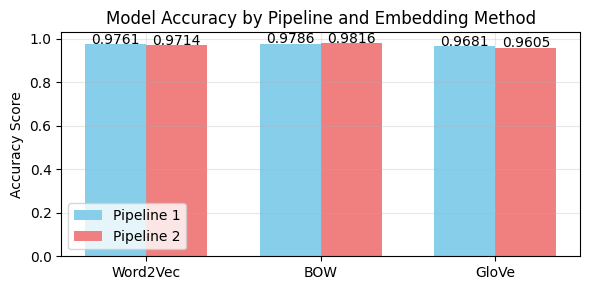

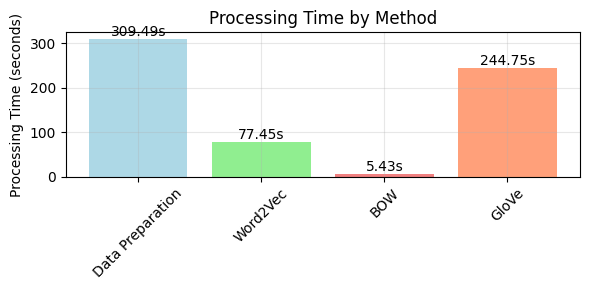

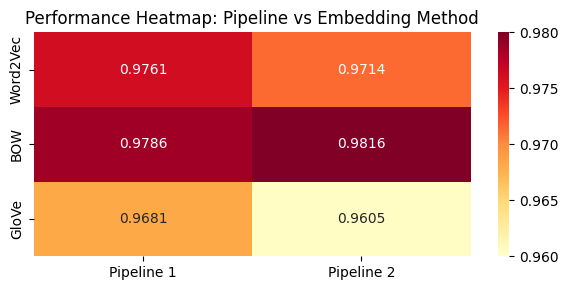

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
methods = ['Word2Vec', 'BOW', 'GloVe']
pipeline1_scores = [0.9761, 0.9786, 0.9681]
pipeline2_scores = [0.9714, 0.9816, 0.9605]

# Create grouped bar plot
plt.figure(figsize=(6,3))
x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, pipeline1_scores, width, label='Pipeline 1', color='skyblue')
plt.bar(x + width/2, pipeline2_scores, width, label='Pipeline 2', color='lightcoral')

plt.ylabel('Accuracy Score')
plt.title('Model Accuracy by Pipeline and Embedding Method')
plt.xticks(x, methods)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(pipeline1_scores):
    plt.text(i - width/2, v + 0.001, f'{v:.4f}', ha='center')
for i, v in enumerate(pipeline2_scores):
    plt.text(i + width/2, v + 0.001, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Prepare timing data
methods = ['Data Preparation', 'Word2Vec', 'BOW', 'GloVe']
times = [309.49, 77.45, 5.43, 244.75]

plt.figure(figsize=(6, 3))
bars = plt.bar(methods, times, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.ylabel('Processing Time (seconds)')
plt.title('Processing Time by Method')
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create heatmap data
performance_data = {
    'Pipeline 1': pipeline1_scores,
    'Pipeline 2': pipeline2_scores
}
df_heatmap = pd.DataFrame(performance_data, index=methods[1:])


plt.figure(figsize=(6, 3))
sns.heatmap(df_heatmap, annot=True, fmt='.4f', cmap='YlOrRd', 
            center=0.97, vmin=0.96, vmax=0.98)
plt.title('Performance Heatmap: Pipeline vs Embedding Method')
plt.tight_layout()
plt.show()

# Report

## Conclusion
- Word2Vec and BOW are the best performing models for this dataset.
- GloVe is the worst performing model for this dataset.
- Pipeline 2 is the best performing model for this dataset.
- Pipeline 1 is the second best performing model for this dataset.

## Recommendation
- Use Word2Vec and BOW for this dataset.
- Use Pipeline 2 for this dataset.


## Reference(s):
Singh, A. (n.d.). Fake News Classification. Kaggle. Retrieved January 17, 2025, from https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data